In [30]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell

# Hyperparameters

In [45]:
train_length = 1000
test_length = 1500

discount_rate = 0.99
rnn_size = 10

sampling_rate = 200
striding = 100



In [15]:
def downgrade_and_feature(array):
    nchannels = array.shape[0]
    data_length = array.shape[1]
    
    temp = np.zeros(data_length)
    
    for j in range(data_length):
        for i in range(nchannels):
            temp[j] += array[i][j]
        temp[j]/=nchannels
    
    reduced_length = int(data_length/striding)

    averages = np.zeros(reduced_length, dtype = np.float32)   
    variations = np.zeros(reduced_length, dtype = np.float32)
    
    for i in range(reduced_length):
        averages[i] = np.average(temp[striding*i:striding*(i+1)])
        variations[i] = np.var(temp[striding*i:striding*(i+1)])
        
    return {'averages' : averages,'variations' : variations}

In [4]:
def dataload(patient_number, dataset_number):
    try :
        input_folder_path = '/home/maestoj/medical_analysis/eeg_csv'
        input_data_name = 'data{}_{}.csv'.format(patient_number,dataset_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [17]:
def time_axis_maker(array, sec_per_cell,init = 0):
    final = init + sec_per_cell*(len(array)-1)
    return np.linspace(init,final,len(array))

# Onset-time data

In [20]:
def seizure_time_parser(onset_times,patient_number,data_set_number):
    temp = str(onset_times[patient_number-1][data_set_number])
    curr_onset_time = []
    while temp.find('/')!=-1:
        curr_onset_time.append(int(temp[0:temp.find('/')]))
        temp=temp[temp.find('/')+1:]
    curr_onset_time.append(int(float(temp)))
    curr_onset_time=np.array(curr_onset_time)
    return curr_onset_time

In [21]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times_temp=[]

for row in reader:
    onset_times_temp.append(row)
    
onset_times = []
total_patient = len(onset_times_temp)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]

for i in range(total_patient):
    event_number[i] = len(onset_times_temp[i])-1

for p in range(total_patient):
    temp = []
    for d in range(event_number[p]):
        temp.append(seizure_time_parser(onset_times_temp,p+1,d+1))
    onset_times.append(temp)

In [22]:
print("The number of datasets of patients")
print(event_number)
print("1st patient's seizure time for each data_set")
print(onset_times[0])
print("9th patient's seizure time for each data_set")
print(onset_times[8])

The number of datasets of patients
[ 7  7  6  3 10  1  7 13 16  8  8  5  3  6 31  8  2  4]
1st patient's seizure time for each data_set
[array([820]), array([781]), array([626]), array([713]), array([807]), array([792]), array([780])]
9th patient's seizure time for each data_set
[array([200]), array([312]), array([624]), array([762]), array([752]), array([772]), array([884]), array([502]), array([ 94, 258]), array([836]), array([650]), array([636]), array([576]), array([656]), array([638]), array([706])]


In [27]:
temp = dataload(1,1)
print(temp.shape)
result = downgrade_and_feature(temp)
print(result['averages'].shape)
print(result['variations'].shape)
time = time_axis_maker(result['averages'], striding/sampling_rate)

data1_1.csv is loaded
(22, 315200)
(3152,)
(3152,)


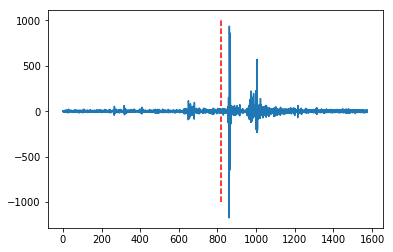

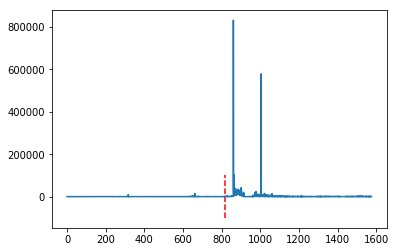

In [29]:
plt.plot(time, result['averages'])
plt.vlines(onset_times[0][0], -1000, 1000, colors='r', linestyles='--')
plt.show()

plt.plot(time, result['variations'])
plt.vlines(onset_times[0][0], -100000, 100000, colors='r', linestyles='--')
plt.show()

# Training_set

In [48]:
def train_set_generator(patient_number, dataset_number):
    
    result = downgrade_and_feature(dataload(patient_number,dataset_number))
    onset_time_temp = onset_times[patient_number-1][dataset_number-1]        

    if len(onset_time_temp) > 1:
        print("More than one onset time")
        return
    
    onset_time_temp = onset_time_temp[0]
    print(onset_time_temp)
    
    if onset_time_temp*sampling_rate/striding < train_length:
        print("Wrong input")
        return
    
    input_data = np.zeros((2,train_length))
    output_data = np.zeros(train_length)
    
    for i in range(train_length):
        if i==0:
            output_data[train_length-1] = 1
        else :
            output_data[train_length-1-i] = discount_rate*output_data[train_length-i] 

    onset_on_array = int(onset_time_temp*sampling_rate/striding)
    
    for i in range(train_length):
        input_data[0][i] = result['averages'][onset_on_array-train_length+1+i]
        input_data[1][i] = result['variations'][onset_on_array-train_length+1+i]

    return {'input' : input_data, 'output' : output_data}

data1_1.csv is loaded
820


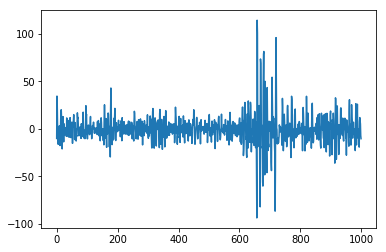

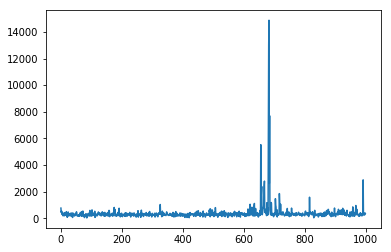

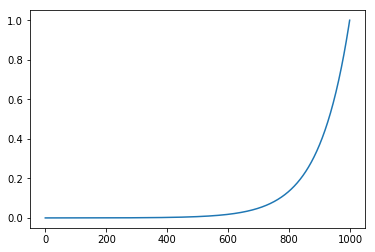

(2, 1000)
(1000,)


In [49]:
result = train_set_generator(1,1)
plt.plot(result['input'][0])
plt.show()
plt.plot(result['input'][1])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

data1_3.csv is loaded
626


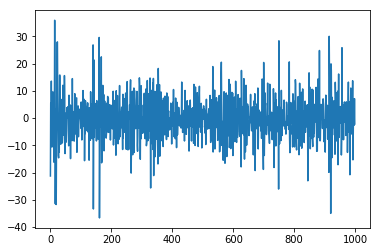

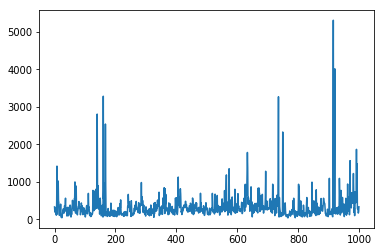

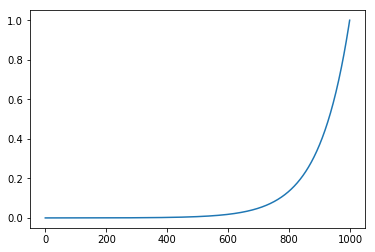

(2, 1000)
(1000,)


In [51]:
result = train_set_generator(1,3)
plt.plot(result['input'][0])
plt.show()
plt.plot(result['input'][1])
plt.show()
plt.plot(result['output'])
plt.show()
print(result['input'].shape)
print(result['output'].shape)

# Neural network

In [52]:
x = tf.placeholder(tf.float32, shape=[2,train_length])
y = tf.placeholder(tf.float32, shape=[train_length])
test_x = tf.placeholder(tf.float32, shape=[2,test_length])

rnn_tei_x = tf.transpose(test_x,[1,0])
rnn_tei_x = tf.split(0,test_length,rnn_tei_x)

rnn_tri_x = tf.transpose(x,[1,0])
rnn_tri_x = tf.split(0,train_length,rnn_tri_x)

with tf.variable_scope("rnn") as scope:
    lstm_cell = rnn_cell.LSTMCell(rnn_size)

    W = tf.Variable(tf.truncated_normal([rnn_size,1], stddev=0.01))
    b = tf.Variable(tf.constant(0.01, shape=[1]))
    
    initial_state = lstm_cell.zero_state(1, tf.float32)
    
    outputs, states = rnn.rnn(lstm_cell, inputs = rnn_tri_x, initial_state = initial_state, dtype=tf.float32)
    temp_outputs = tf.pack(outputs)
    temp_outputs = tf.reshape(temp_outputs,[-1,rnn_size])
    temp_outputs = tf.matmul(temp_outputs,W)+b
    print(temp_outputs)
    
    scope.reuse_variables()
    test_outputs, test_states = rnn.rnn(lstm_cell, inputs = rnn_tei_x, initial_state = initial_state, dtype =tf.float32)
    temp_test_outputs = tf.pack(test_outputs)
    temp_test_outputs = tf.reshape(temp_test_outputs, [-1,rnn_size])
    temp_test_outputs = tf.matmul(temp_test_outputs,W)+b
    print(temp_test_outputs)
    temp_y = tf.reshape(y, [-1,1])
    print(temp_y)

Tensor("rnn/add:0", shape=(1000, 1), dtype=float32)
Tensor("rnn/add_1:0", shape=(700, 1), dtype=float32)
Tensor("rnn/Reshape_2:0", shape=(1000, 1), dtype=float32)


In [57]:
cost = tf.reduce_mean(tf.square(temp_outputs-temp_y))
train = tf.train.AdamOptimizer(1e-3).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

KeyboardInterrupt: 

train_data_set = []
temp_train_data_set = [1,6,8,9,10,11,12,14,15,16,17,18]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21]
train_data_set.append(temp_train_data_set)
temp_train_data_set = [1,8,9,10,16,17]
train_data_set.append(temp_train_data_set)
print(train_data_set)

data1_1.csv is loaded
820


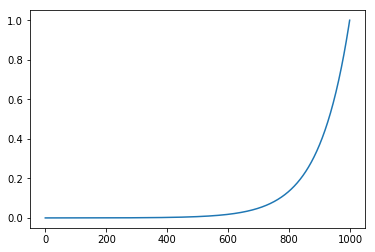

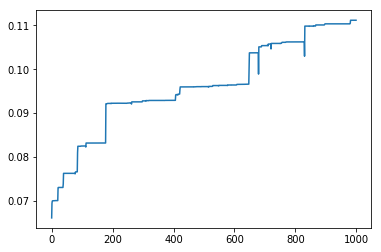

Cost = 37.77650451660156


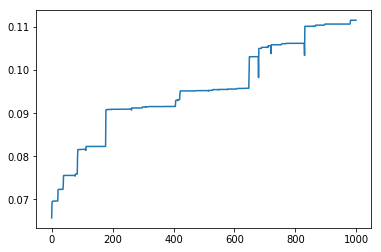

Cost = 12.799644470214844


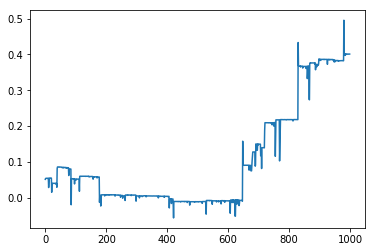

Cost = 9.070531845092773


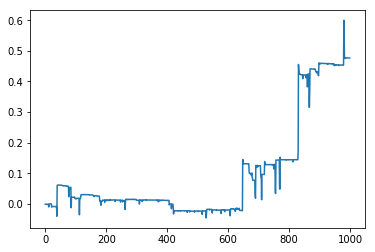

Cost = 7.442418098449707


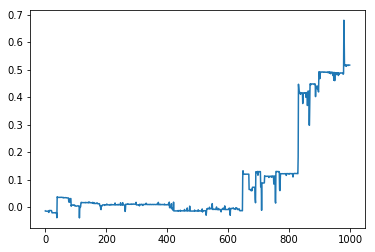

Cost = 6.340982913970947


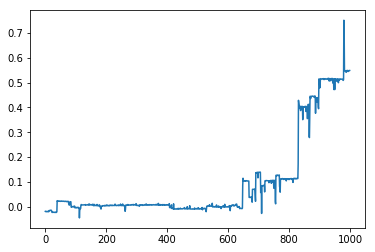

Cost = 5.509557723999023


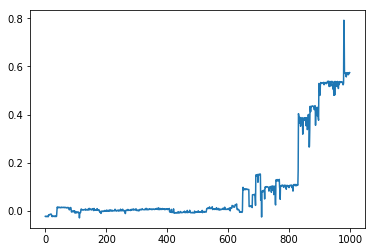

Cost = 4.681475639343262


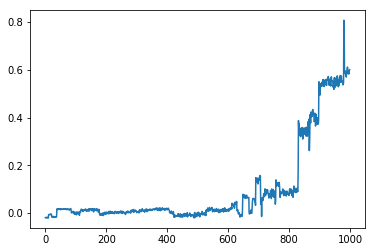

Cost = 3.8016393184661865


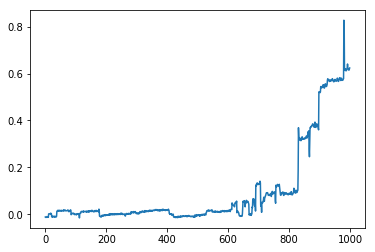

Cost = 3.1579513549804688


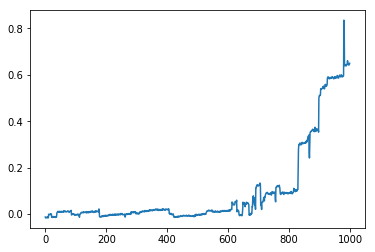

Cost = 2.584071636199951


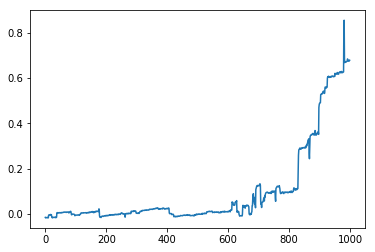

Cost = 1.9520164728164673


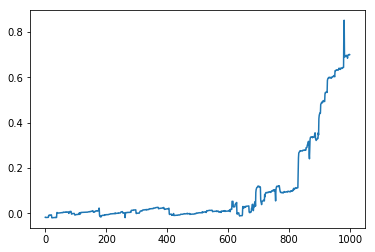

In [56]:
for i in range(len(onset_times)):
    for j in range(len(onset_times[i])):
        if len(onset_times[i][j])>1:
            continue;
        onset_time_temp = onset_times[i][j][0]
        if onset_time_temp*sampling_rate/striding < train_length:
            continue;
        print("Patient {} and dataset {}".format(i+1,j+1))
        result = train_set_generator(i+1, j+1)
        input_data = result['input']
        output_data = result['output']
        plt.plot(output_data)
        plt.show()
        plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
        plt.show()
        for i in range(1001):
            opt, c = sess.run([train, cost], feed_dict={x: input_data, y: output_data})
            print("Before Cost = {}".format(c))
        print("After Cost = {}".format(c))
        plt.plot(sess.run(temp_outputs, feed_dict = {x : input_data}))
        plt.show()

# Test_set_generator

In [59]:
def test_set_generator(patient_number, dataset_number):
    result = downgrade_and_feature(dataload(patient_number,dataset_number))
    input_data = np.zeros((2,test_length))
    for i in range(test_length):
        input_data[0][i] = result['averages'][i]
        input_data[1][i] = result['variations'][i]

    return {'input' : input_data}

In [60]:
test_patient_number = 1
test_dataset_number = 1 
result = test_set_generator(test_patient_number, test_dataset_number)
input_data = result['input']
time = time_axis_maker(input_data[0],striding/sampling_rate)
plt.plot(time, input_data)
plt.show()
plt.plot(time, sess.run(temp_test_outputs, feed_dict = {test_x : input_data}))
plt.show()
plt.vlines(onset_times[test_patient_number-1][test_dataset_number-1],0, 1, colors='r', linestyles='--')

data1_1.csv is loaded


KeyboardInterrupt: 